# spectral clustering illustration


adapted from https://github.com/blubars/Spectral-Clustering/blob/master/jupyter/spectral-clustering-notebook.ipynb


## 1. create toy datasets


In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

n_samples = 100
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
datasets = [noisy_circles, noisy_moons]

X, y = datasets[1]

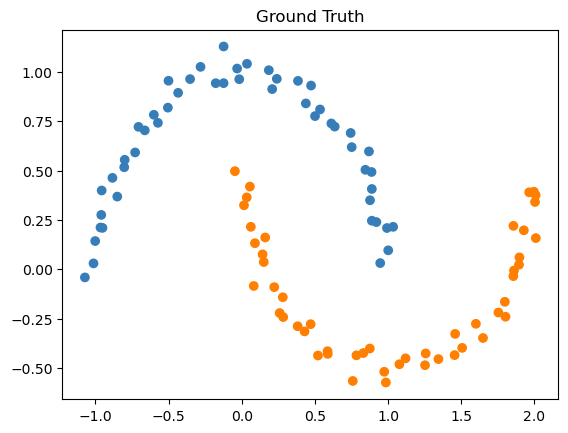

In [2]:
def plot_results(X, y, fignum, title):
    # plot with true labels
    fig = plt.figure(fignum)
    plt.title(title)
    colors = ['#377eb8', '#ff7f00','#000000']
    y_colors = [colors[label] for label in y]
    plt.scatter(X[:,0], X[:,1], color=y_colors)
    # plt.gca().set_aspect('equal')
    plt.show()
    
plot_results(X, y, 1, "Ground Truth")

# 2. Counter example: KMeans clustering not working for non-convex shape


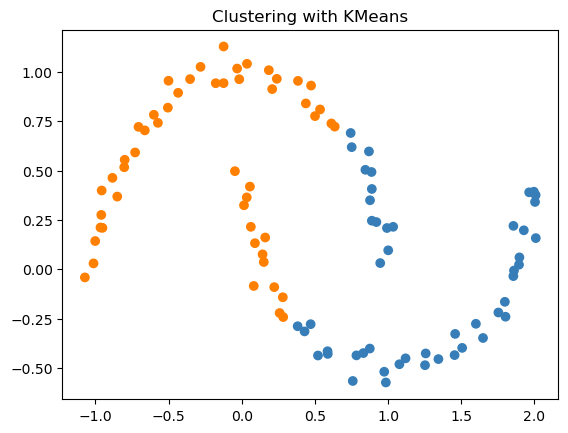

In [3]:
from sklearn.cluster import KMeans

# try clustering with KMeans for comparision
km = KMeans(n_clusters=2, n_init='auto')
km.fit(X)
y_pred = km.labels_

# plot results
plot_results(X, y_pred, 2, "Clustering with KMeans")

## 3. Build (undirected weighted) graph in terms of affinity matrix


use Gaussian kernel for similarity function


In [4]:
X[0]

array([ 1.86096171, -0.00611569])

In [5]:
from math import exp

num_clusters = 2
sigma_sq = .01

def affinity_kernel(x1, x2):
    # compute the affinity of samples X1, X2
    return exp(-(np.linalg.norm(x1-x2)**2)/(2*sigma_sq))

In [6]:
# construct affinity matrix
A = np.zeros((len(X), len(X)))
for i in range(len(X)-1):
    for j in range(i+1, len(X)):
        A[i,j] = affinity_kernel(X[i], X[j])
        A[j,i] = A[i,j]

# # print affinity matrix
np.set_printoptions(precision=2)
# print(A)

### if we use the following tensor computation, there will be numerical instability that fails clustering


In [28]:
def compute_affinity_matrix(points):
    # Compute pairwise Euclidean distances
    pairwise_distances = np.linalg.norm(points[:, np.newaxis] - points, axis=2)

    # Compute the affinity matrix using the RBF kernel
    affinity_matrix = np.exp(-pairwise_distances**2 / (2 * sigma_sq**2))

    return affinity_matrix

points(N,2) first expand to points\[:,np.newaxis\](N,1,2), then minus points(N,2), the results broadcast to (N,N,2)


In [29]:
A = compute_affinity_matrix(X)

## 4. Compute Laplacian


In [7]:
# Construct diagonal degree matrix
D = np.zeros(A.shape)
for i in range(A.shape[0]):
    D[i,i] = np.sum(A[i,:])

print(D)

[[3.23 0.   0.   ... 0.   0.   0.  ]
 [0.   3.16 0.   ... 0.   0.   0.  ]
 [0.   0.   2.49 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 2.87 0.   0.  ]
 [0.   0.   0.   ... 0.   1.72 0.  ]
 [0.   0.   0.   ... 0.   0.   2.41]]


In [8]:
# Construct Laplacian Matrix:
#   L = I - D^{-1/2} A D^{-1/2} --> L[i,j] = I[i,j] - A[i,j]/sqrt(d_i * d_j)

# D^{-1/2}:
Dinvsq = np.sqrt(np.linalg.inv(D))

L = np.dot(Dinvsq, D-A)
L = np.dot(L, Dinvsq)

print(L)
print(np.isclose(L[0,1], -A[0,1]/np.sqrt(D[1,1]*D[0,0])))
print(np.isclose(L[0,0], 1-A[0,0]/np.sqrt(D[0,0]*D[0,0])))

[[ 1.00e+000 -7.15e-005 -4.65e-040 ... -3.41e-027 -7.91e-124 -2.26e-019]
 [-7.15e-005  1.00e+000 -1.17e-058 ... -8.10e-029 -3.87e-124 -6.61e-036]
 [-4.65e-040 -1.17e-058  1.00e+000 ... -5.55e-021 -2.24e-062 -1.90e-006]
 ...
 [-3.41e-027 -8.10e-029 -5.55e-021 ...  1.00e+000 -7.04e-037 -1.73e-022]
 [-7.91e-124 -3.87e-124 -2.24e-062 ... -7.04e-037  1.00e+000 -2.47e-090]
 [-2.26e-019 -6.61e-036 -1.90e-006 ... -1.73e-022 -2.47e-090  1.00e+000]]
True
True


In [9]:
# Find the K largest eigenvectors of L
eigvals, eigvects = np.linalg.eigh(L)

best_eigens = [i for i in range(num_clusters)]
print(best_eigens)

[0, 1]


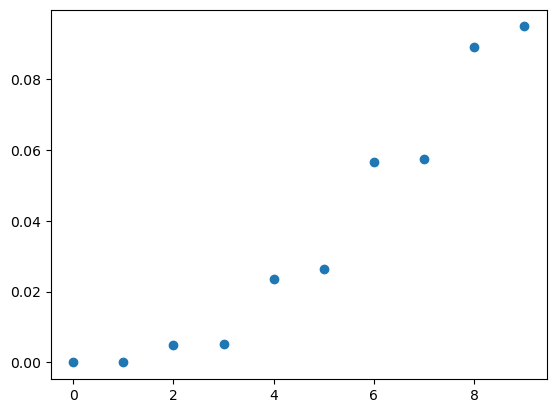

In [10]:
plt.scatter(x=range(0,10),y=eigvals[0:10])

In [11]:
eigvals[0:2]

array([1.28e-18, 2.96e-06])

In [12]:
eigvects.shape

(100, 100)

we get the matrix $U$ and pick the first k-columns (first k eigenvectors) to form the matrix $U_{n\times k}$


In [13]:
U = np.zeros((L.shape[0],num_clusters))
U = eigvects[:,best_eigens]
U.shape

(100, 2)

normalize the rows to norm 1


In [14]:
U = (U.T / np.linalg.norm(U, axis=1)).T
np.linalg.norm(U, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
print("Eigenvalues:")
print(eigvals)

Eigenvalues:
[1.28e-18 2.96e-06 5.05e-03 5.36e-03 2.37e-02 2.63e-02 5.65e-02 5.75e-02
 8.91e-02 9.49e-02 1.44e-01 1.93e-01 2.00e-01 2.24e-01 2.58e-01 2.81e-01
 3.10e-01 3.72e-01 3.85e-01 4.86e-01 4.96e-01 5.39e-01 6.05e-01 6.33e-01
 6.65e-01 6.84e-01 7.62e-01 8.09e-01 8.16e-01 8.27e-01 9.29e-01 9.53e-01
 9.78e-01 1.01e+00 1.02e+00 1.05e+00 1.05e+00 1.09e+00 1.12e+00 1.12e+00
 1.13e+00 1.17e+00 1.18e+00 1.18e+00 1.22e+00 1.23e+00 1.25e+00 1.25e+00
 1.26e+00 1.26e+00 1.26e+00 1.28e+00 1.28e+00 1.29e+00 1.29e+00 1.30e+00
 1.30e+00 1.30e+00 1.30e+00 1.30e+00 1.30e+00 1.31e+00 1.31e+00 1.31e+00
 1.31e+00 1.32e+00 1.32e+00 1.32e+00 1.33e+00 1.33e+00 1.33e+00 1.33e+00
 1.34e+00 1.34e+00 1.34e+00 1.34e+00 1.35e+00 1.35e+00 1.35e+00 1.35e+00
 1.35e+00 1.36e+00 1.36e+00 1.36e+00 1.36e+00 1.36e+00 1.37e+00 1.37e+00
 1.39e+00 1.39e+00 1.40e+00 1.40e+00 1.41e+00 1.41e+00 1.41e+00 1.42e+00
 1.43e+00 1.44e+00 1.45e+00 1.60e+00]


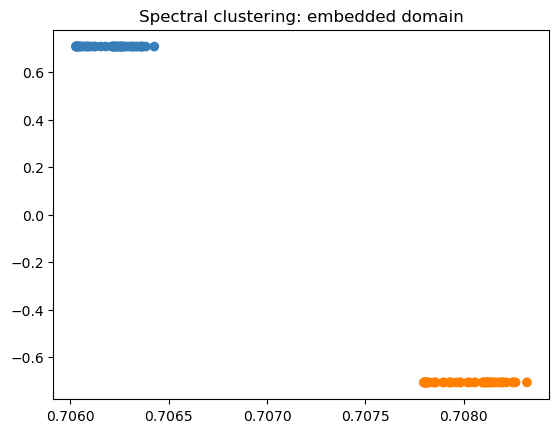

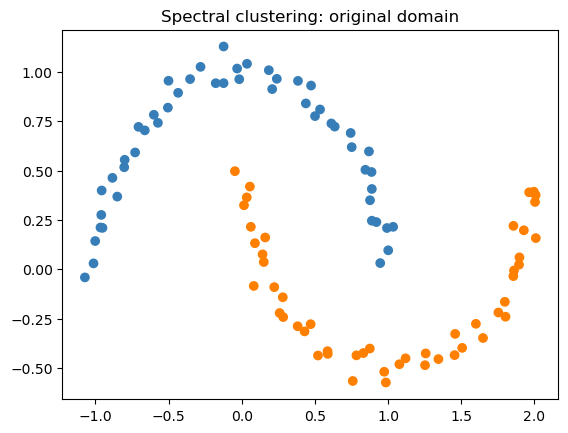

In [17]:
# Finally, do clustering on reduced space using KMeans:
km2 = KMeans(n_clusters=2, n_init='auto')
km2.fit(U)
y_pred = km2.labels_
#y_pred = [1 if x > 0 else 0 for x in LX]

# plot results
plot_results(U, y_pred, 3, "Spectral clustering: embedded domain")
plot_results(X, y_pred, 3, "Spectral clustering: original domain")